# Review Sentiment Classification Notebook


## Summary
Text Classification aims to assign a text instance into one or more class(es) in a predefined set of classes.

## Description 
### Use Case Description
A company, such as bank, wants to analyze customer feedback in order to provide additional insight to enhance market campaign prediction. The bank collects customers feedback from public website. The task is to build a pipeline that automatically analyzes customer feedback messages, to provide the overall sentiment for the bank. The aim is to help the bank who wants to more accurately predict the success of telemarketing calls for selling bank long-term deposits gain extra features from social media.

#### Use Case Data
The data used in this use case is [BankReview dataset](https://www.creditkarma.com/reviews/banking/single/id/Simple#single-review-listingPaper), a publicly available data set collected from credit karma website. The data comprises approximately 120 customers feedback. 

We shared the review data as a Blob in a public Windows Azure Storage account. You can use this shared data to follow the steps in this template, or you can collect more feedbacks from credit karma website.

Each instance in the data set has 3 fields:

* customerid - the customer who posted the feedback 
* sentiment - the polarity of the feedback (1 = strongly negative, 2 = negative, 3 = neutral, 4 = positive, 5 = strongly positive)
* review - the text of the feedback 

### Step 1 - Data Preparation

### Load data from Local
Start by loading data from local to IPython Notebook using Pandas. Then, use some simple visualization techniques to peak at the data.

In [1]:
# Load the bank review dataset
import csv
import pandas as pd

text_df = pd.read_csv('./data/BankReviewTrainingSample.csv')
text_df.head()

,sentiment,review
0,4,I absolutely love my bank. There's a reason th...
1,1,International transaction fees for items bough...
2,5,This bank bends over backwards for its custome...
3,5,I have used this bank for going on two years a...
4,5,This card makes it so easy to save.... for rai...


In [2]:
text_df.columns = ['label_column', 'text_column'] #rename column names
label_column = text_df["label_column"]
text_df["label_column"] = label_column.map(lambda label: 1 if label == 4 or label == 5 else 0) #replace label 4 to label 1
text_df = text_df.dropna()

In [3]:
text_df.head()

,label_column,text_column
0,1,I absolutely love my bank. There's a reason th...
1,0,International transaction fees for items bough...
2,1,This bank bends over backwards for its custome...
3,1,I have used this bank for going on two years a...
4,1,This card makes it so easy to save.... for rai...


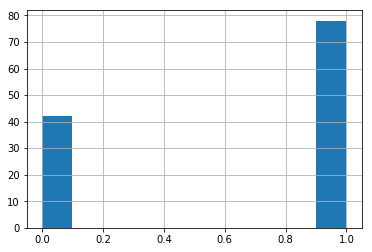

In [4]:
import matplotlib 

%matplotlib inline
text_df["label_column"].hist()

### Step 2 - Text Preprocessing

Unstructured text such as tweets, product reviews, or search queries usually requires some preprocessing before it can be analyzed. This experiment includes a number of optional text preprocessing and text cleaning steps, such as replacing special characters and punctuation marks with spaces, normalizing case, removing duplicate characters, removing user-defined or built-in stop-words, and word stemming.

In this step, the user can visualize the most frequent words for each class. In the sentiment analysis use case, the first word cloud, shown below, represents the top positive sentiment-bearing words while the second word cloud shows the most frequent negative sentiment-bearing words in the input training corpus. This visualization helps us validate the quality of the training data before start to build the classification model in the next step.

In [6]:
import string
stop_words_df = pd.read_csv('./data/StopWords.csv')
stop_words = set(stop_words_df["Col1"].tolist())
for item in string.ascii_lowercase: #load stop words
    if item != "i":
        stop_words.add(item)

In [7]:
from nltk.tokenize import RegexpTokenizer
text_column = []
for line in text_df.text_column:
    value = " ".join(item.lower()
                     for item in RegexpTokenizer(r'\w+').tokenize(line)
                     if item.lower() not in stop_words)
    text_column.append(value)
text_df.text_column = text_column

In [8]:
text_df.head()

,label_column,text_column
0,1,i absolutely love my bank reason bank customer...
1,0,international transaction fees for items bough...
2,1,bank bends backwards for its customers i ve on...
3,1,i used bank for going on years it best bank ap...
4,1,card makes it so easy to save for rainy days f...


### Visualize the most frequent 50 words in both positive and negative classes
Use wordcloud package to visualize the most frequent words in both positive and negative class as a word cloud. These most frequent words will give us initial understanding of the text.

In [9]:
from IPython.display import Image
positive_text = " ".join(text_df[text_df.label_column == 1].text_column.tolist())
negative_text = " ".join(text_df[text_df.label_column == 0].text_column.tolist())

# Generate word 

try:
    from wordcloud import WordCloud
except ImportError:
    print ("Missing wordcloud module")
else:
    import matplotlib.pyplot as plt
    try:
        positive_word_cloud = WordCloud(max_words=50, margin=10, random_state=1).generate(positive_text)
        default_colors = positive_word_cloud.to_array()
        plt.title("Top 50 words in positive class")
        plt.imshow(default_colors)
        plt.axis("off")
        image = plt.show()
        negative_word_cloud = WordCloud(max_words=50, margin=10, random_state=1).generate(negative_text)
        default_colors = negative_word_cloud.to_array()
        plt.title("Top 50 words in negative class")
        plt.imshow(default_colors)
        plt.axis("off")
        image = plt.show()
    except IOError as error:
        print ("Missing WordCloud data")

Missing wordcloud module


### Step 3 - Feature Engineering 

The aim of this step is to convert variable-length unstructured text data into equal-length numeric feature vectors. The user has the option to try two types of text representations: N-Gram TF and Unigrams TF-IDF. Here, we chose the unigrams TF-IDF feature extraction method.

Then, we performed feature selection to reduce the size of the data. We used the Chi-squared score function to rank the hashing features in descending order, and returned the top 30 most relevant features with respect to the sentiment label, out of all the extracted unigrams.

### Stem and Tokenization

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer

Initialize stemmer to remove morphological affixes from words, leaving only the word stem, and convert the text_column in data frame as a list for future process.

In [11]:
stemmer = PorterStemmer()
text_list = text_df["text_column"].tolist()

Tokenize the sentences in text_list and remove morphological affixes from words.

In [12]:
def stem_tokens(tokens, stemmer_model):
    '''
    :param tokens: tokenized word list
    :param stemmer: remove stemmer
    :return:  tokenized and stemmed words
    '''
    return [stemmer_model.stem(original_word) for original_word in tokens]


def tokenize(text):
    '''
    :param text: raw test
    :return: tokenized and stemmed words
    '''
    tokens = text.strip().split(" ")
    return stem_tokens(tokens, stemmer)

### Unigrams TF-IDF feature extraction

#### Create the Word Dictionary
First, extract the set of unigrams (words) that will be used to train the text model. In addition to the unigrams, the number of documents where each word appears in the text corpus is counted (DF). It is not necessary to create the dictionary on the same labeled data used to train the text model -- any large corpus that fairly represents the frequency of words in the target domain of classification can be used, even if it is not annotated with the target categories.

#### TF-IDF Calculation
When the metric word frequency of occurrence (TF) in a document is used as a feature value, a higher weight tends to be assigned to words that appear frequently in a corpus (such as stop-words). The inverse document frequency (IDF) is a better metric, because it assigns a lower weight to frequent words. You calculate IDF as the log of the ratio of the number of documents in the training corpus to the number of documents containing the given word. Combining these numbers in a metric (TF/IDF) places greater importance on words that are frequent in the document but rare in the corpus. This assumption is valid not only for unigrams but also for bigrams, trigrams, etc.

This experiment converts unstructured text data into equal-length numeric feature vectors where each feature represents the TF-IDF of a unigram in a text instance.

Initialize the TfidfVectorizer to compute tf-idf for each word

In [13]:
tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words='english', max_df=160000,
                        min_df=9, norm="l2", use_idf=True)
tfs = tfidf.fit_transform(text_list)
print(tfs)
tfs

  (0, 2)	0.221753831939
  (0, 49)	0.368544633283
  (0, 13)	0.406986984004
  (0, 26)	0.242029788625
  (0, 75)	0.124843206538
  (0, 46)	0.160383216913
  (0, 60)	0.227581612941
  (0, 19)	0.16500416833
  (0, 18)	0.202485683627
  (0, 10)	0.153999605087
  (0, 65)	0.211429246413
  (0, 1)	0.198425214393
  (0, 28)	0.160383216913
  (0, 52)	0.266452574283
  (0, 77)	0.106567331634
  (0, 4)	0.232457541703
  (0, 85)	0.202485683627
  (0, 27)	0.194596902167
  (0, 40)	0.16996771502
  (0, 67)	0.227581612941
  (1, 4)	0.311352804109
  (1, 84)	0.579671474006
  (1, 36)	0.442011991718
  (1, 44)	0.609644004953
  (2, 13)	0.285643697073
  :	:
  (118, 28)	0.131942194735
  (118, 52)	0.109601048415
  (118, 77)	0.175339139512
  (118, 4)	0.0956177299141
  (118, 84)	0.356038999546
  (118, 30)	0.141988120997
  (118, 73)	0.154283341055
  (118, 35)	0.16008871037
  (118, 72)	0.192475782951
  (118, 78)	0.163238141632
  (118, 38)	0.732912257642
  (118, 58)	0.15159500074
  (118, 59)	0.178019499773
  (119, 49)	0.702475767354

<120x92 sparse matrix of type '<class 'numpy.float64'>'
	with 1606 stored elements in Compressed Sparse Row format>

### Perform Feature Selection using Chi-squared Test
The Chi-squared statistic measures dependence between stochastic variables, so a transformer based on this function "weeds out" the features that are the most likely to be independent of class and therefore irrelevant for classification.

In [14]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [15]:
labels = text_df.label_column.tolist()  # Load labels
# Perform chi-squared test to select top 30 features
selected_features = SelectKBest(chi2, k=30).fit_transform(tfs, labels)
selected_features

<120x30 sparse matrix of type '<class 'numpy.float64'>'
	with 492 stored elements in Compressed Sparse Row format>

### Step 4 - Train and Evaluate Models with Different Top K Words

In this step, users can train and evaluate text classification models using state-of-the-art ML algorithms ranging from Two-Class Logistic Regression, Two-Class Support Vector Machine and Two-Class Boosted Decision Tree for binary text classification to One-vs-All Multiclass, Multiclass Logistic Regression and Multiclass Decision Forest for multi-class text classification. The user will also find the Sweep Parameters module that allows her to get the optimal values for the underlying learning algorithm parameters. In the case of binary models, the user has the advantage of visualizing the weights assigned to different words/unigrams that help her justify the decision of the trained model. Here, we used Two-Class Logistic Regression classifier as an example.


### Select Top Features
Select top k words based on Chi-squared test score to formalize the feature vector.
The features for this task is the words in different sentence, if we choose to use all words as features, then the feature space will become very large and sparse, which makes the training process much slower.
Besides that feature selection will also simplify our model and reduce the chance of overfitting.





In [16]:
def select_top_features(chi_square, top_k_features, tf_idf_features, label_list):
    '''
    :param chi2: chi squared feature selctor
    :param top_k: number of top features
    :param tfs: tf-idf feature list
    :param labels: labels of the feature list
    :return: feature list after chi squared test
    '''
    return SelectKBest(chi_square, k=top_k_features).fit_transform(tf_idf_features, label_list)

### Split Data for Training and Testing
Split the transformed feature vectors into 80% as training set and 20% as test set.
Training set is used to train a classifier and test set is used to test the performance of the trained classifier.

In [17]:
from sklearn.cross_validation import train_test_split

def split_data(selected_features_list, label_list):
    '''
    :param selected_features: feature list after feature selection
    :param labels: labels of the feature list
    :return: 80% training set and 20% test set
    '''
    return train_test_split(selected_features_list, label_list, test_size=0.2, random_state=12345)

C:\Users\dsvmadmin\AppData\local\AmlWorkbench\Python\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Initialize Sweep Parameter
To find the optimal parameters for the logistic regression, we test both l1 and l2 regularization with different regularization parameters C (0.1, 1 and 10). Usually a classifier will have several parameters to tune in order to get the best performance. These regularization parameters are used to avoid overfitting on the training set.

In [18]:
def make_sweep_parameter_dict():
    '''
    :return: parameters of logistic regression model to tune
    '''
    return {"penalty": ("l1", "l2"), "C": [0.1, 1, 10]}

### Sweep Parameters with Logistic Regression using Cross Validation
Use 3-fold cross validation to find the optimal parameters for logistic regression algorithm, then train the algorithm with all training data and the optimal parameters. 3-fold cross validation will first split the training set into 3 equal sized subsamples. Of the 3 subsamples, a single subsample is retained as the validation set for testing the model, and the remaining k-1 subsamples are used as training data. The cross validation process is repeated 3 times with each of the 3 subsamples used exactly once as the validation data.

In [19]:
from sklearn import grid_search
from sklearn.linear_model import LogisticRegression

def sweep_logistic_regression_cross_val(train_feature, train_label):
    '''
    :param train_x: feature of training set
    :param train_y: label of training set
    :return: trained logistic regression model
    '''
    model = LogisticRegression()
    classifier = grid_search.GridSearchCV(model, make_sweep_parameter_dict())
    classifier.fit(train_feature, train_label)
    return classifier

C:\Users\dsvmadmin\AppData\local\AmlWorkbench\Python\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Validate Model using Testing Data
The probability of each record in test set is calculated by the trained model to calculate the AUC. AUC (area under the curve) is an important metric to evaluate the performance of the classifier. The value of the AUC lies in range [0, 1] and the bigger AUC means better performance.

In [20]:
def prediction(classifier, test_feature):
    '''
    :param clf: the trained classifier
    :param test_x: feature of test set
    :return: score probability of test set
    '''
    return [classifier.predict_proba(feature)[0][1] for feature in test_feature]

### Compute AUC
Compute the AUC based on the label and the scores of test set and prepare input to plot ROC curve. In statistics, a ROC (receiver operating characteristic curve), is a graphical plot that illustrates the performance of a binary classifier system as its discrimination threshold is varied. And AUC is the area under ROC curve.

In [21]:
from sklearn import metrics

def calc_auc(test_label, predict_probability_list):
    '''
    :param test_y: label of test set
    :param predict: score probability of test set
    :return: falst positive list, true positive list,, AUC
    '''
    fpr_list, tpr_list = metrics.roc_curve(test_label,
                                           predict_probability_list, pos_label=1)[:-1]
    auc = metrics.auc(fpr_list, tpr_list)
    return fpr_list, tpr_list, auc

### Put it all together
We select different top k words list based on Chi-squared test, and then a 3-fold cross validation is used to find the optimal parameters for the logistic regression algorithm based on the top k words. We trained the logistic regression algorithm with the optimal parameters, test its performance on test set and plot the ROC curve for each top k words list

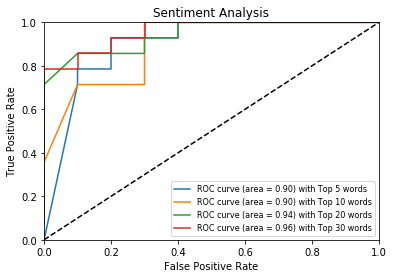

In [22]:
import pylab as pl

top_k_list = [5, 10, 20, 30]  #Select top words to see performance
pl.clf()
for top_k in top_k_list:
    selected_features = select_top_features(chi2, top_k, tfs, labels)
    train_x, test_x, train_y, test_y = split_data(selected_features, labels)
    clf = sweep_logistic_regression_cross_val(train_x, train_y)
    predict = prediction(clf, test_x)
    fpr, tpr, roc_auc = calc_auc(test_y, predict)
    pl.plot(fpr, tpr, label='ROC curve (area = %0.2f) with Top %d words' % (roc_auc, top_k))
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Sentiment Analysis')
pl.legend(loc="lower right", prop={'size':8})
pl.show()